# Analyzing All of Manmohan Singh's Speeches 

###### Now that we have all the files scraped, the idea is to look at them to see if we can get something interesting out of this.

In [1]:
#Putting all the import packages over here.
import pandas as pd
import re
pd.options.display.max_columns = 30  #Can't have too many columns.
import glob
from datetime import datetime
import dateutil.parser
import nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']= (17,5)
from collections import Counter
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import KMeans
import langid
from tqdm import tqdm

In [2]:
#Going into the folder and checking if all the speeches are loaded
folder = nltk.data.find(
    '/home/harsha/Desktop/Projects/indian-pm-speeches/manmohansingh/')
paths = glob.glob('Projects/indian-pm-speeches/manmohansingh/*')
len(paths)  #To see if all the files have loaded.

1349

In [3]:
mms_speeches = [
]  #We make an empty dataframe to store all the content of speeches in a list.
for path in paths:
    corpusReader = nltk.corpus.PlaintextCorpusReader(
        folder,
        path.split('/')[-1])  #Using NLTK to identify number of sentences.
    number_of_sentences = len(corpusReader.sents())
    number_of_words = len(
        [word for sentence in corpusReader.sents() for word in sentence])
    with open(
            path, encoding="utf-8"
    ) as speech_file:  #Converting all the content into a dictionary.
        filename = path.split('/')[-1]
        date = re.search(
            '([A-Z])\w+_([0-9])+',
            filename)  #Extracting the date of the speech from the filename
        city = re.search(r'(\d+)_([A-Z]\w+_\d+_\d\d\d\d)(_*?)([A-Z]\w+.+).txt',
                         filename)  #Extracting the location of the speech.
        if date:
            date = datetime.strptime(date.group(0), '%B_%d_%Y')
        else:
            date = np.nan
        if city:
            city = city.group(4).replace('_', ' ')
        else:
            city = np.nan
        speech = {
            'filename': path.split('/')[-1],
            'content': speech_file.read(),
            'date': date,
            'city': city,
            'number_of_sentences': number_of_sentences,
            'number_of_words': number_of_words,
            'average_sentence_length': number_of_words / number_of_sentences
        }
    mms_speeches.append(speech)
mms_df = pd.DataFrame(
    mms_speeches)  # We convert the list to a dataframe. Easy!
mms_df.head()  #Checking if it worked. YES!

,average_sentence_length,city,content,date,filename,number_of_sentences,number_of_words
0,25.345455,Haridwar,I am extremely happy to be here today to lay t...,2006-10-19,418_October_19_2006_Haridwar.txt,55,1394
1,25.572650,Ahmedabad,"""It gives me great pleasure to be here to inau...",2005-01-03,58_January_3_2005_Ahmedabad.txt,117,2992
2,25.326923,New Delhi,It is my pleasure to welcome you all on the oc...,2008-06-30,667_June_30_2008_New_Delhi.txt,52,1317
3,28.532787,New Delhi,"""There is someone who said, 'truth is learning...",2005-09-01,176_September_1_2005_New_Delhi.txt,122,3481
4,27.500000,New York,President Musharraf and Prime Minister Dr. Ma...,2004-09-24,21_September_24_2004_New_York.txt,8,220


In [4]:
mms_df.index = mms_df['date']  #Setting a dateindex
mms_df.head()

,average_sentence_length,city,content,date,filename,number_of_sentences,number_of_words
date,,,,,,,
2006-10-19,25.345455,Haridwar,I am extremely happy to be here today to lay t...,2006-10-19,418_October_19_2006_Haridwar.txt,55,1394
2005-01-03,25.572650,Ahmedabad,"""It gives me great pleasure to be here to inau...",2005-01-03,58_January_3_2005_Ahmedabad.txt,117,2992
2008-06-30,25.326923,New Delhi,It is my pleasure to welcome you all on the oc...,2008-06-30,667_June_30_2008_New_Delhi.txt,52,1317
2005-09-01,28.532787,New Delhi,"""There is someone who said, 'truth is learning...",2005-09-01,176_September_1_2005_New_Delhi.txt,122,3481
2004-09-24,27.500000,New York,President Musharraf and Prime Minister Dr. Ma...,2004-09-24,21_September_24_2004_New_York.txt,8,220


Let's see some basic descriptive numbers. 

In [5]:
mms_df.describe()

,average_sentence_length,number_of_sentences,number_of_words
count,1349.000000,1349.000000,1349.000000
mean,51.982104,56.422535,1323.142328
std,272.736594,39.961286,899.070231
min,12.025000,1.000000,47.000000
25%,21.000000,30.000000,694.000000
50%,22.960000,49.000000,1144.000000
75%,25.111111,74.000000,1709.000000
max,4015.000000,317.000000,8341.000000


That's some disparity between the mean and the median.

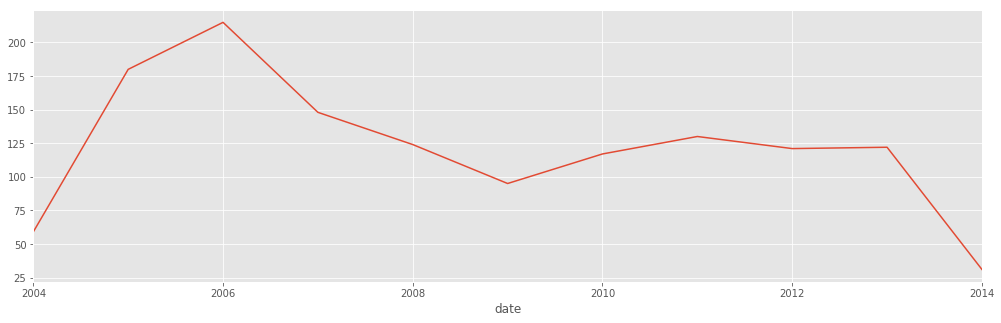

In [6]:
#Let's look at the number of speeches he's given each year from 2004 to 2014
plt.style.use('ggplot')
mms_df.groupby(by=mms_df.index.year)['filename'].count().plot()

He gave the maximum number of speeches in 2006 and the least in 2014, obviously. 

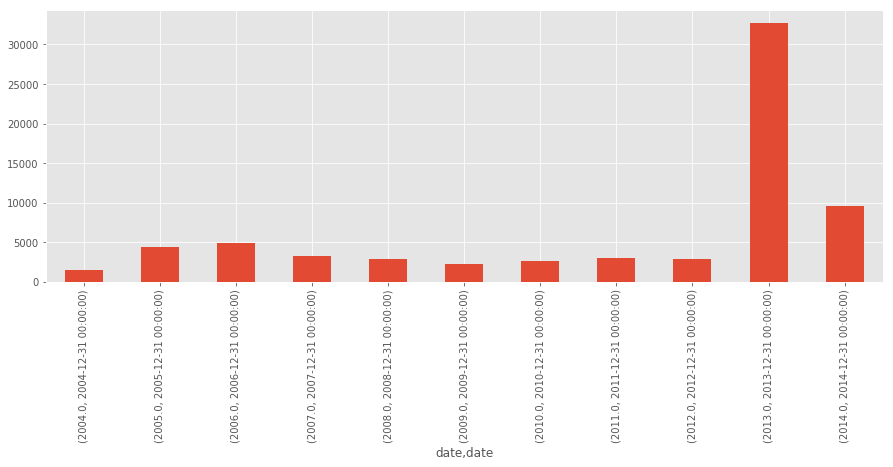

In [7]:
ax1 = mms_df['average_sentence_length'].groupby(
    by=mms_df.index.year).resample('A').sum().plot(
        figsize=(15, 5), kind='bar')

What's with that huge spike above?

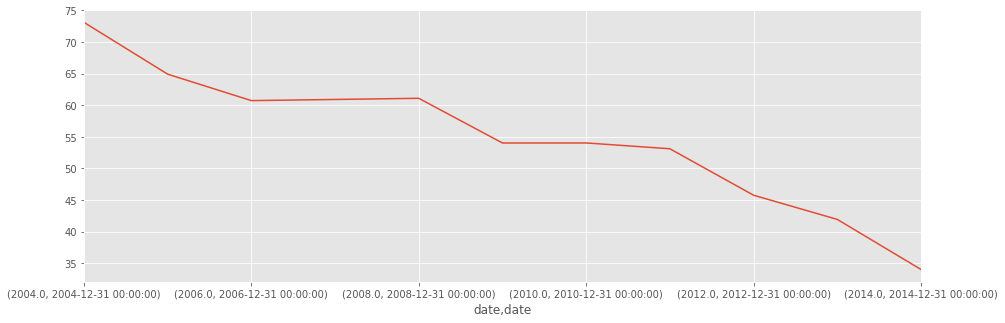

In [8]:
#The average number of sentences went download gradually. 
ax1 = mms_df['number_of_sentences'].groupby(
    by=mms_df.index.year).resample('A').mean().plot(figsize=(15, 5))

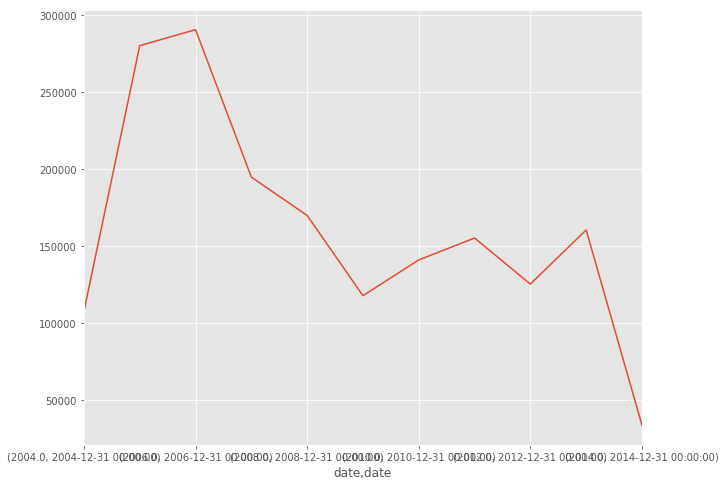

In [9]:
mms_df['number_of_words'].groupby(
    by=mms_df.index.year).resample('A').sum().plot(figsize=(10, 8))

# Word Occurances in his speeches

In [10]:
#Words whose occurances we would want to track
list_of_words = [
    "india", "indian", "indians", "freedom", "democracy", "nation", "world",
    "environment", "oil", "jobs", "education", "employment", "security",
    "terrorism", "pakistan", "china", "u.s", "america", "u.s.a", "i", "we",
    "you", "our", "ours", "me"
]

In [11]:
#Word Count Function
def get_word_time_trend(x, word):
    text_string = re.sub('', '', x).lower().split()
    c = 0
    for w in text_string:
        if (w == word):
            c += 1
    return c

In [12]:
#Can't forget to normalize
def normalize(x, y):
    return (1000 * x) / y

In [13]:
df = mms_df.copy()

In [14]:
for word in list_of_words:
    df['t_' + word] = df.content.apply(lambda x: get_word_time_trend(x, word))

In [15]:
df2 = df[df.index.isnull() == False]

In [16]:
for word in list_of_words:
    df2['n_' + word] = df2.apply(
        lambda x: normalize(x['t_' + word], x['number_of_words']), axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


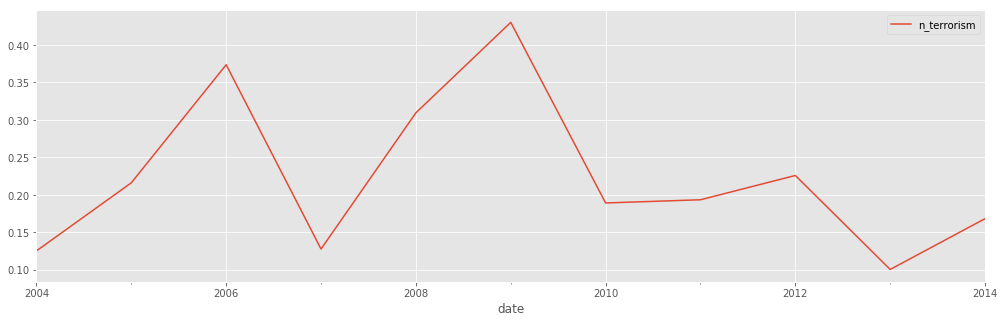

In [17]:
df2.filter(items=['n_terrorism']).resample('A').mean().plot()

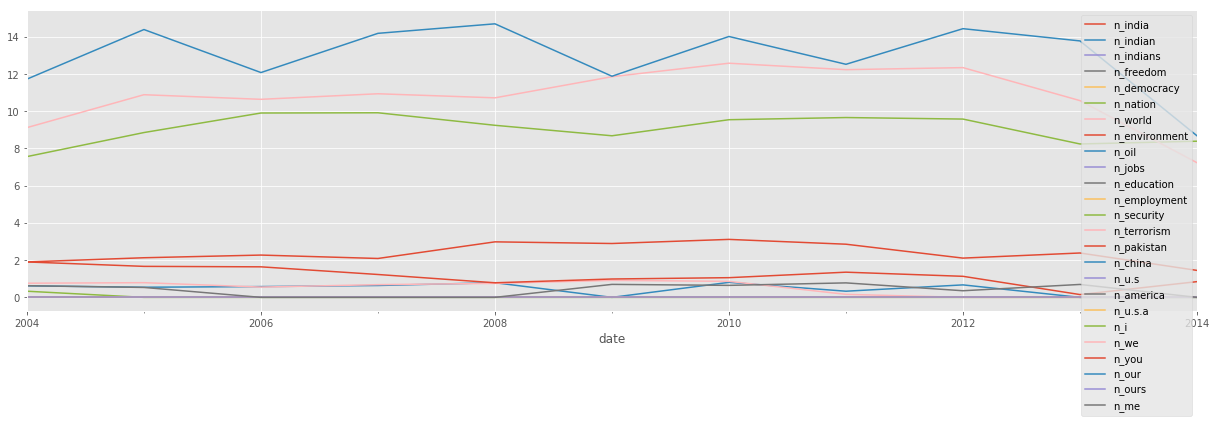

In [18]:
df2.filter(regex = 'n_').resample('A').median().plot();
plt.tight_layout()

# Analyzing Speeches Themselves

While a lot of MMS's speeches are in English, a few of his speeches were in Hindi. His successor has much more Hindi Speeches.

In [19]:
mms_df['language'] = np.nan

In [20]:
def language_classifier(x):
    return langid.classify(x['content'])


In [21]:
mms_df['language']=mms_df.content.apply(lambda x: langid.classify(x)[0])

In [22]:
mms_english = mms_df[mms_df['language'] == 'en']
mms_hindi = mms_df[mms_df['language'] == 'hi']

In [23]:
mms_english = mms_english.reset_index(drop=True)
mms_hindi = mms_hindi.reset_index(drop=True)

In [24]:
mms_english_bag_of_words = []
for x in tqdm(range(len(mms_english))):
    if pd.isnull(mms_english['content'][x]):
        pass
    else:
        words = mms_english['content'][x].split()
        mms_english_bag_of_words.extend(words)

100%|██████████| 1329/1329 [00:00<00:00, 5531.77it/s]


In [25]:
len(mms_english_bag_of_words)

1556266

In [26]:
import string
mms_english_bag_of_words = [
    element.lower() for element in tqdm(mms_english_bag_of_words)
]
mms_english_bag_of_words = [
    ''.join(c for c in s if c not in string.punctuation)
    for s in tqdm(mms_english_bag_of_words)
]

100%|██████████| 1556266/1556266 [00:04<00:00, 380973.96it/s]


In [27]:
mms_english_fdist = nltk.FreqDist(mms_english_bag_of_words)

In [28]:
len(mms_english_fdist)

28921

In [29]:
mms_english_fdist.most_common(50)

[('the', 94740),
 ('of', 68200),
 ('and', 56386),
 ('to', 52564),
 ('in', 40673),
 ('a', 28242),
 ('our', 24177),
 ('that', 21427),
 ('we', 21061),
 ('is', 20040),
 ('i', 17298),
 ('for', 16181),
 ('this', 15215),
 ('have', 14682),
 ('are', 10612),
 ('be', 10195),
 ('on', 9826),
 ('with', 9530),
 ('has', 9356),
 ('as', 9085),
 ('it', 9004),
 ('will', 8920),
 ('india', 7075),
 ('all', 6724),
 ('an', 6331),
 ('by', 5992),
 ('also', 5814),
 ('which', 5025),
 ('at', 4983),
 ('not', 4913),
 ('been', 4832),
 ('you', 4650),
 ('these', 4523),
 ('development', 4355),
 ('from', 4320),
 ('people', 4272),
 ('government', 4237),
 ('must', 4137),
 ('can', 4118),
 ('more', 3828),
 ('country', 3810),
 ('their', 3746),
 ('new', 3743),
 ('there', 3630),
 ('am', 3580),
 ('but', 3536),
 ('was', 3472),
 ('need', 3358),
 ('growth', 3246),
 ('world', 3219)]

In [30]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
new_mms_english_bag_of_words = [
    w for w in tqdm(mms_english_bag_of_words) if w not in stopwords
]

100%|██████████| 1556266/1556266 [00:03<00:00, 408061.99it/s]


In [31]:
len(new_mms_english_bag_of_words)

822405

In [32]:
mms_fdist_new = nltk.FreqDist(new_mms_english_bag_of_words)

In [33]:
mms_fdist_new.most_common(50)

[('india', 7075),
 ('also', 5814),
 ('development', 4355),
 ('people', 4272),
 ('government', 4237),
 ('must', 4137),
 ('country', 3810),
 ('new', 3743),
 ('need', 3358),
 ('growth', 3246),
 ('world', 3219),
 ('us', 3199),
 ('would', 3175),
 ('economic', 3055),
 ('national', 3027),
 ('one', 2620),
 ('years', 2587),
 ('today', 2567),
 ('indian', 2560),
 ('many', 2515),
 ('work', 2442),
 ('great', 2317),
 ('countries', 2299),
 ('state', 2244),
 ('like', 2204),
 ('', 2147),
 ('important', 2080),
 ('global', 2066),
 ('public', 2056),
 ('security', 2038),
 ('economy', 1971),
 ('time', 1944),
 ('education', 1939),
 ('year', 1913),
 ('energy', 1898),
 ('sector', 1849),
 ('areas', 1733),
 ('social', 1677),
 ('states', 1663),
 ('therefore', 1635),
 ('cooperation', 1601),
 ('hope', 1599),
 ('well', 1578),
 ('make', 1556),
 ('rural', 1546),
 ('take', 1509),
 ('investment', 1500),
 ('ensure', 1482),
 ('two', 1480),
 ('society', 1445)]

In [34]:
from nltk.util import ngrams
mms_english_bigrams = ngrams(new_mms_english_bag_of_words, 2)

In [35]:
mms_english_bigrams_fdist = nltk.FreqDist(mms_english_bigrams)

In [36]:
mms_english_bigrams_fdist.most_common(50)

[(('would', 'like'), 846),
 (('prime', 'minister'), 801),
 (('state', 'governments'), 447),
 (('science', 'technology'), 409),
 (('climate', 'change'), 408),
 (('economic', 'growth'), 391),
 (('per', 'cent'), 378),
 (('two', 'countries'), 345),
 (('united', 'states'), 342),
 (('developing', 'countries'), 341),
 (('work', 'together'), 339),
 (('social', 'economic'), 339),
 (('look', 'forward'), 307),
 (('sections', 'society'), 293),
 (('last', 'year'), 288),
 (('jawaharlal', 'nehru'), 285),
 (('must', 'also'), 278),
 (('people', 'india'), 277),
 (('public', 'sector'), 268),
 (('central', 'government'), 267),
 (('private', 'sector'), 265),
 (('growth', 'rate'), 265),
 (('economic', 'development'), 264),
 (('mahatma', 'gandhi'), 261),
 (('health', 'care'), 252),
 (('energy', 'security'), 249),
 (('ladies', 'gentlemen'), 246),
 (('south', 'asia'), 245),
 (('chief', 'ministers'), 239),
 (('rural', 'areas'), 235),
 (('higher', 'education'), 234),
 (('sincerely', 'hope'), 233),
 (('national',

# Categorizing Speeches

In [37]:
def simple_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    return words

In [38]:
#Vectorizing
vectorizer = TfidfVectorizer(
    use_idf=True, tokenizer=simple_tokenizer, stop_words='english')
X = vectorizer.fit_transform(mms_english['content'])

In [39]:
#5 is a good number of clusters
number_of_clusters = 5
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [40]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_words)))

Cluster 0: energy nuclear india climate global
Cluster 1: science research education scientific technology
Cluster 2: india people s great indian
Cluster 3: india cooperation president countries summit
Cluster 4: government growth development need state


In [41]:
results = pd.DataFrame()
results['text'] = mms_english['content']
results['category'] = km.labels_
results.head(10)

,text,category
0,I am extremely happy to be here today to lay t...,4
1,"""It gives me great pleasure to be here to inau...",1
2,It is my pleasure to welcome you all on the oc...,0
3,"""There is someone who said, 'truth is learning...",4
4,President Musharraf and Prime Minister Dr. Ma...,3
5,SHRI SHIVA RATRI DESHI-KENDRA MAHA-SWAMIJIDr. ...,2
6,"\tMy fellow citizens,\n\tThere is genuine and ...",2
7,"""I am delighted to participate in this opening...",1
8,"Ladies and Gentlemen,\tThis is truly a special...",4
9,"""We have just concluded the First India-Africa...",3


In [42]:
results['category'].value_counts()

4    470
2    410
3    306
1     83
0     60
Name: category, dtype: int64